### Notebook to the identification of infected and bystander cells using a logistic regression classifier 

- **Developed by**: Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Faculty of Medicine, Julius-Maximilian-Universität Würzburg**
- v231212

### Import required modules

In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pywaffle import Waffle
from bioservices import KEGG
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.2
scanpy      1.9.5
-----
PIL                 10.0.0
appdirs             1.4.4
asttokens           NA
attr                23.1.0
backcall            0.2.0
bioservices         1.11.2
bs4                 4.12.2
cattr               NA
cattrs              NA
certifi             2023.07.22
charset_normalizer  3.2.0
colorama            0.4.6
colorlog            NA
comm                0.1.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
easydev             0.12.1
exceptiongroup      1.1.3
executing           1.2.0
h5py                3.9.0
idna                3.4
igraph              0.10.8
importlib_resources NA
ipykernel           6.25.1
ipywidgets          8.1.0
jedi                0.19.0
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.1
llvmlite            0.40.1
louvain             0.8.1
lxml                4.9.3
matplotlib          3.7.2
mpl_toolkits 

### Read in Healthy-CTRL dataset

In [3]:
adata = sc.read_h5ad('../data/Marburg_cell_states_locked_ctl230901.raw.h5ad') 
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels'
    var: 'mt', 'ribo'

### Make a density plot for all viral counts in each group

In [4]:
viral_genes = [gene for gene in adata.var_names if 'NC_' in gene]
adata.obs['viral_counts'] = np.sum(adata[:, viral_genes].X, axis = 1)

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be change

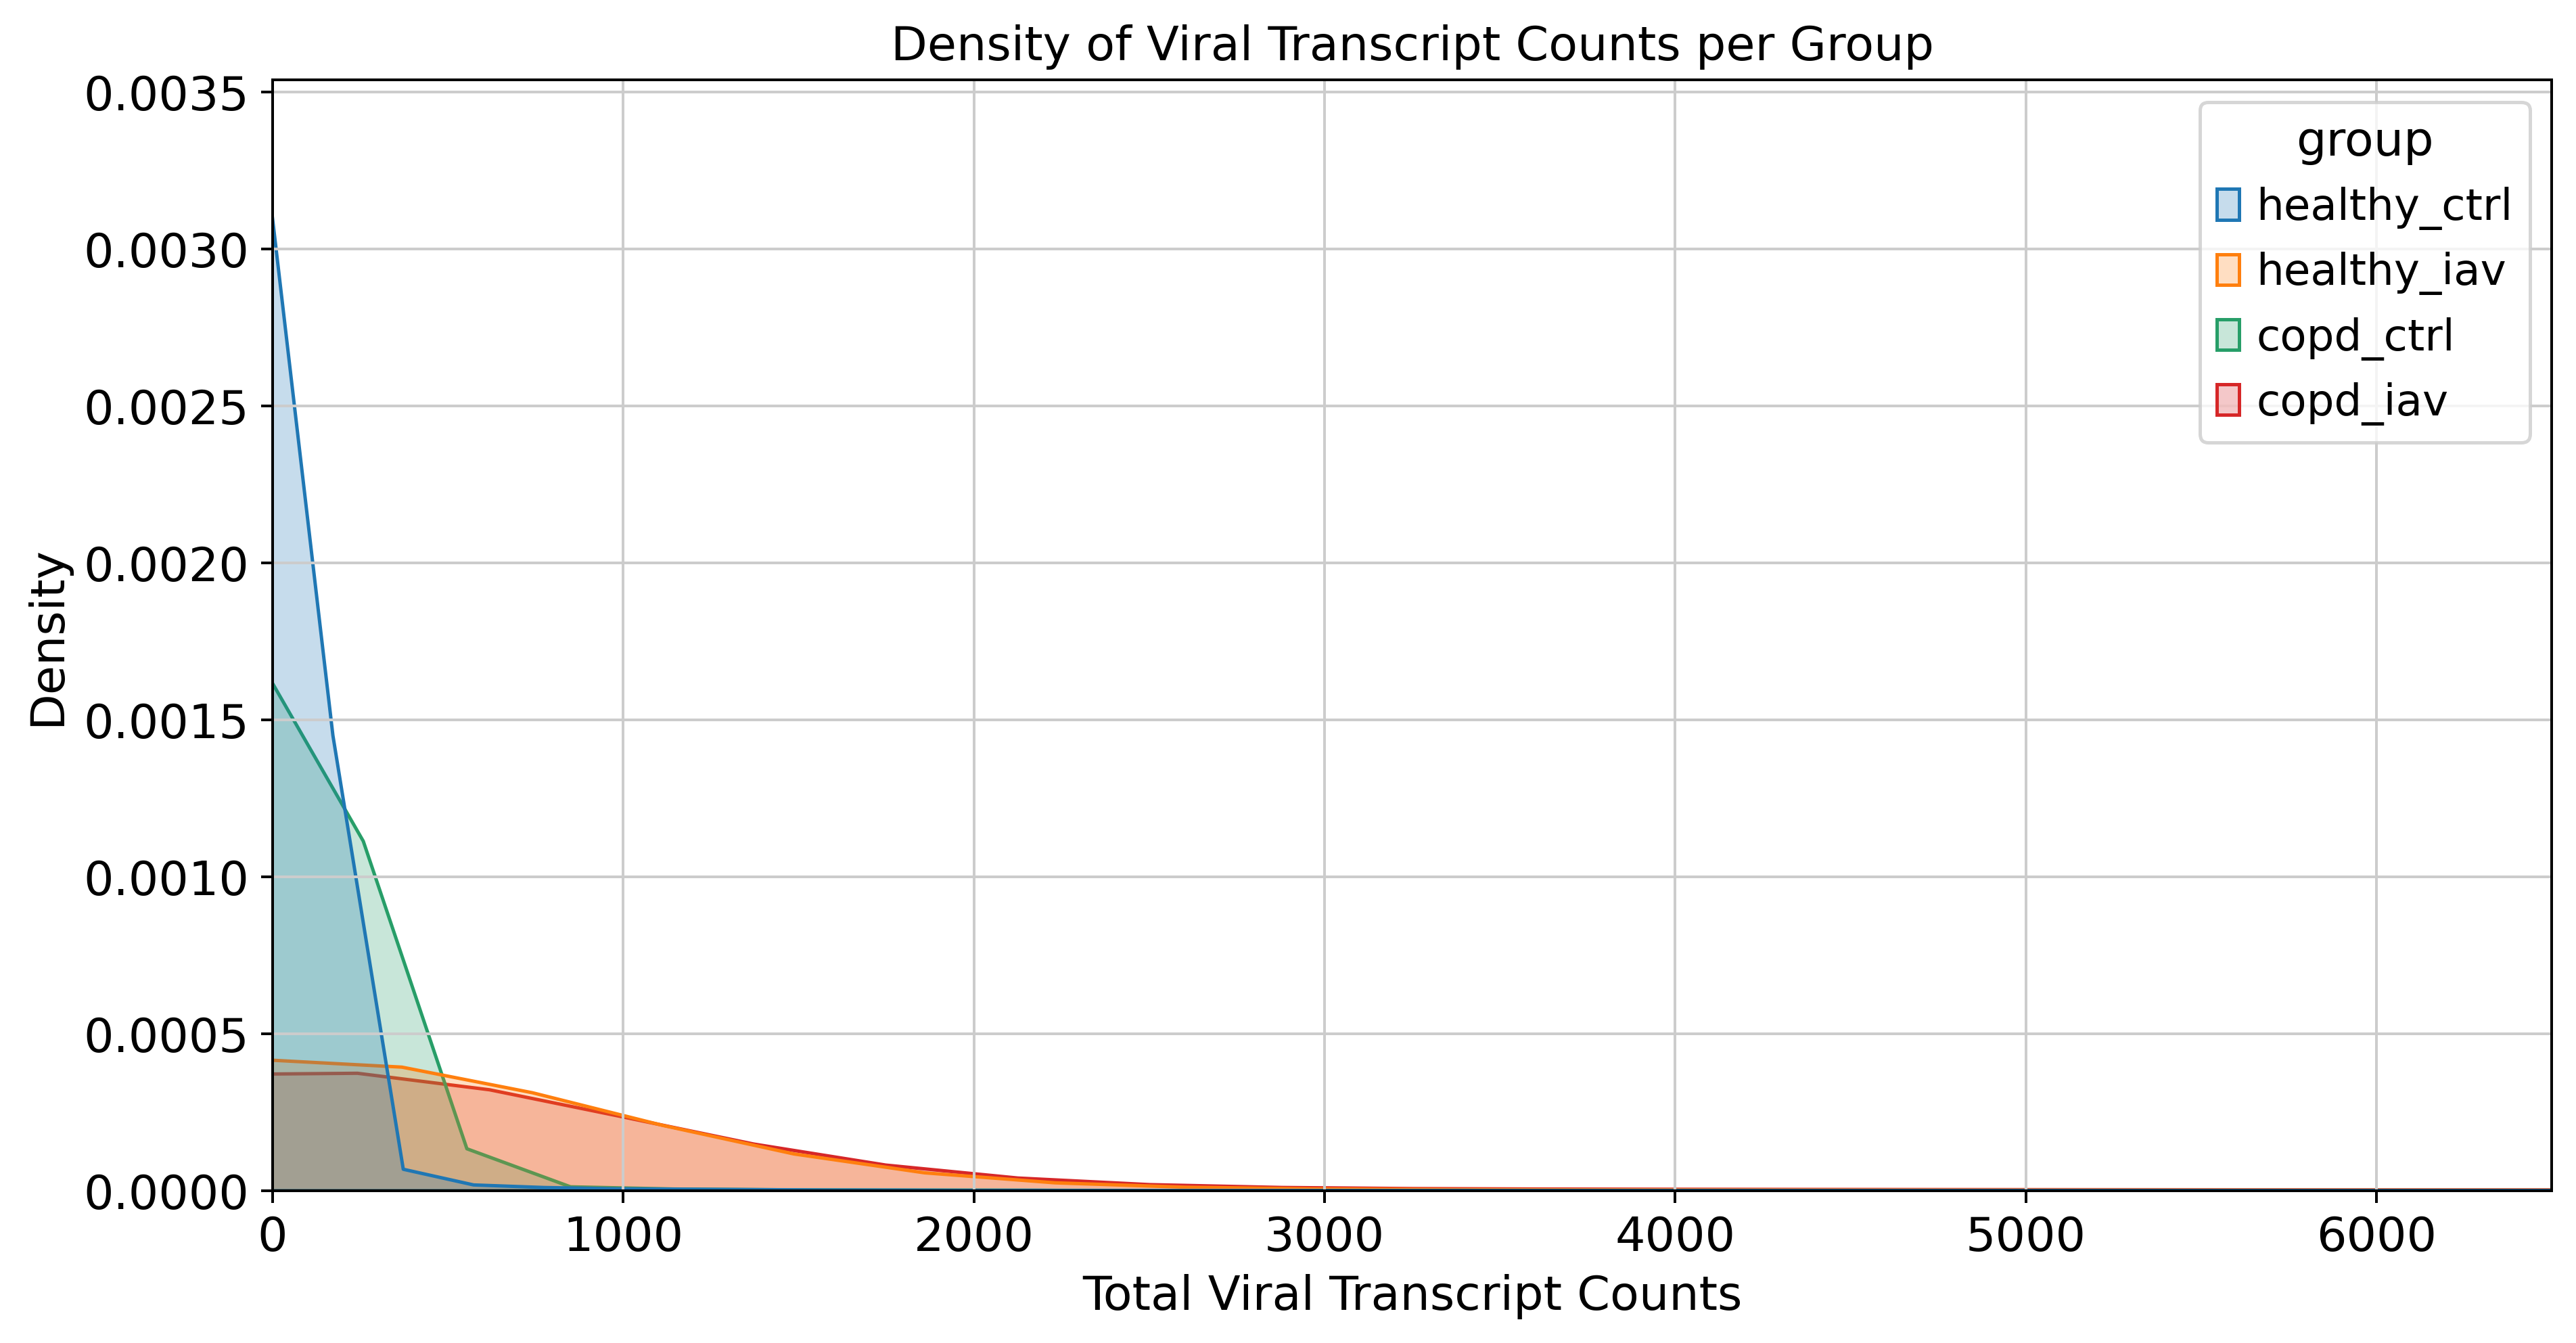

In [5]:
plt.figure(figsize = (12, 6))
sns.kdeplot(data = adata.obs, x = 'viral_counts', hue = 'group', common_norm = False, fill = True)
plt.title('Density of Viral Transcript Counts per Group')
plt.xlabel('Total Viral Transcript Counts')
plt.ylabel('Density')
plt.xlim(0, 6500)
plt.show()

/tmp/ipykernel_2832790/1295881469.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = adata.obs.groupby('group')['viral_counts'].mean()
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


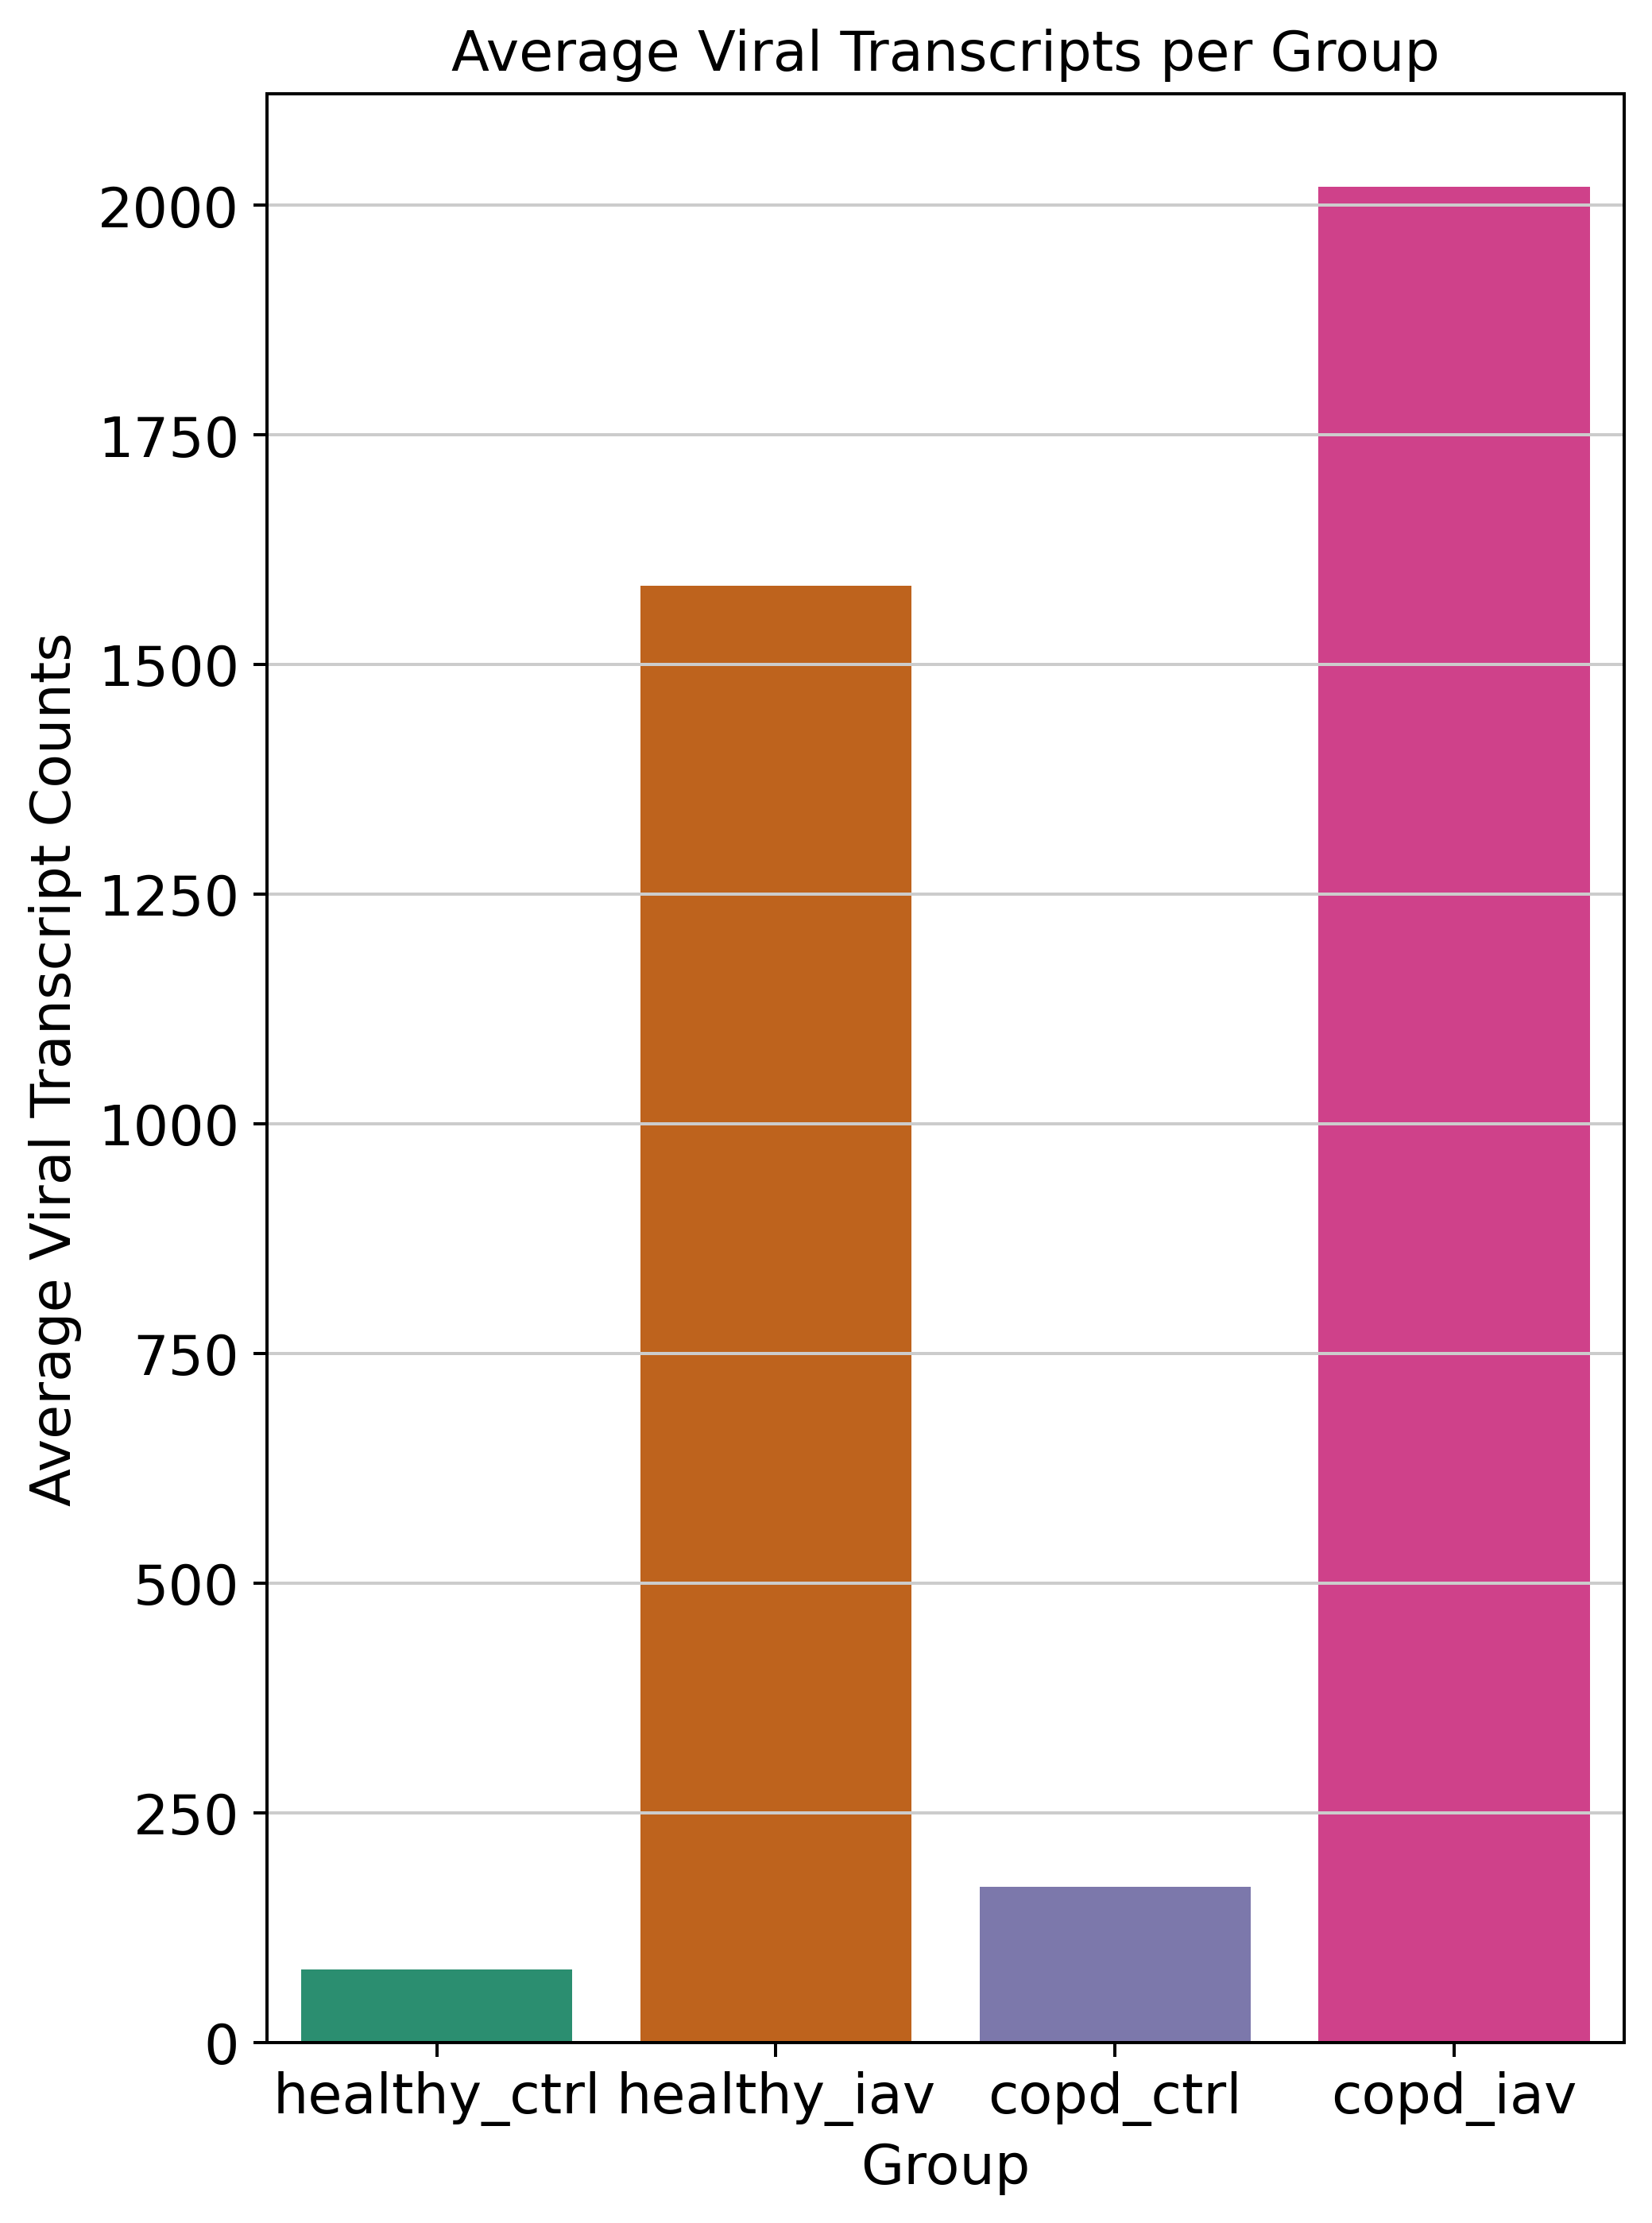

In [6]:
group_means = adata.obs.groupby('group')['viral_counts'].mean()

# Plotting the barplot
plt.figure(figsize = (6, 8))
sns.barplot(x = group_means.index, y = group_means.values, palette = 'Dark2')

plt.xlabel('Group')
plt.ylabel('Average Viral Transcript Counts')
plt.title('Average Viral Transcripts per Group')
plt.tight_layout()
plt.show()

### Create labels for infected, non-infected and bystander/unknown

In [7]:
def classify_cells(row):
    iav_genes = adata.var_names[adata.var_names.str.startswith('NC_')]
    iav_counts = row[adata.var_names.isin(iav_genes)]
    
    total_iav_count = iav_counts.sum()
    
    num_iav_genes_expressed = sum(iav_counts > 0)

    if num_iav_genes_expressed == len(iav_genes) and total_iav_count > 1000:
        return 'infected'
    elif num_iav_genes_expressed <= 2 and total_iav_count < 1000:
        return 'bystander'
    else:
        return 'uninfected'

In [8]:
adata.obs['infection_status'] = [classify_cells(row) for row in adata.X.toarray()]

### Split data for training

In [9]:
X = adata.X
y = adata.obs['infection_status'].values

label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)

X_train, X_test, y_train_int, y_test_int = train_test_split(X, y_int, test_size = 0.2, random_state = 1712)

In [10]:
adata.obs['infection_status'].value_counts()

infection_status
uninfected    88617
infected       5289
bystander      3667
Name: count, dtype: int64

In [11]:
df = adata.obs.groupby(['group', 'infection_status']).size().reset_index(name = 'counts')

grouped = df.groupby('group')['counts'].apply(lambda x: x / x.sum() * 100)
grouped = grouped.reset_index()

df['proportions'] = grouped['counts']
df['waffle_counts'] = (df['proportions'] * 10).astype(int)

/tmp/ipykernel_2832790/2391024188.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(['group', 'infection_status']).size().reset_index(name = 'counts')
/tmp/ipykernel_2832790/2391024188.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('group')['counts'].apply(lambda x: x / x.sum() * 100)


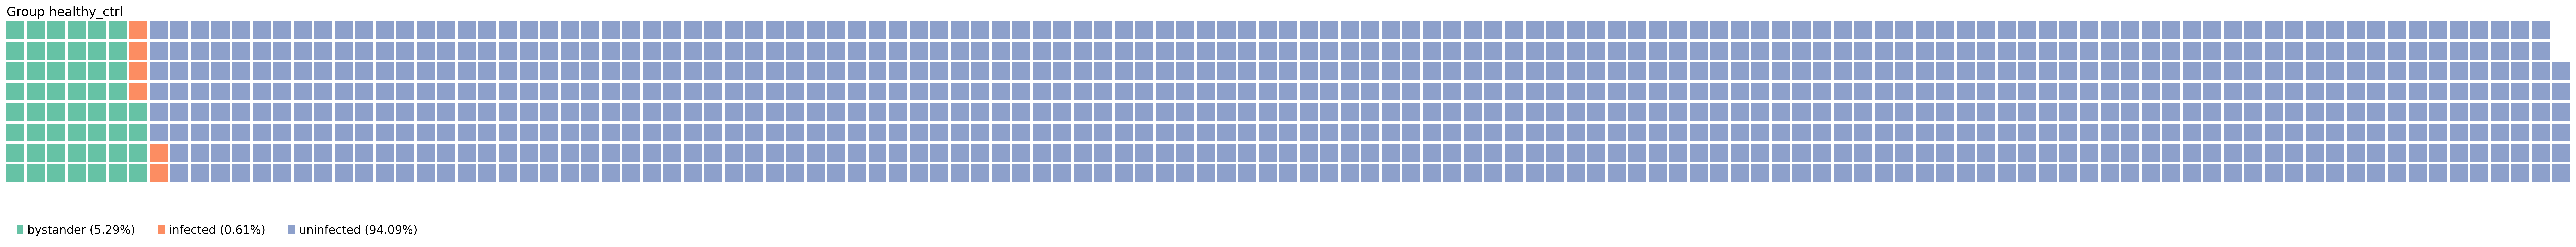

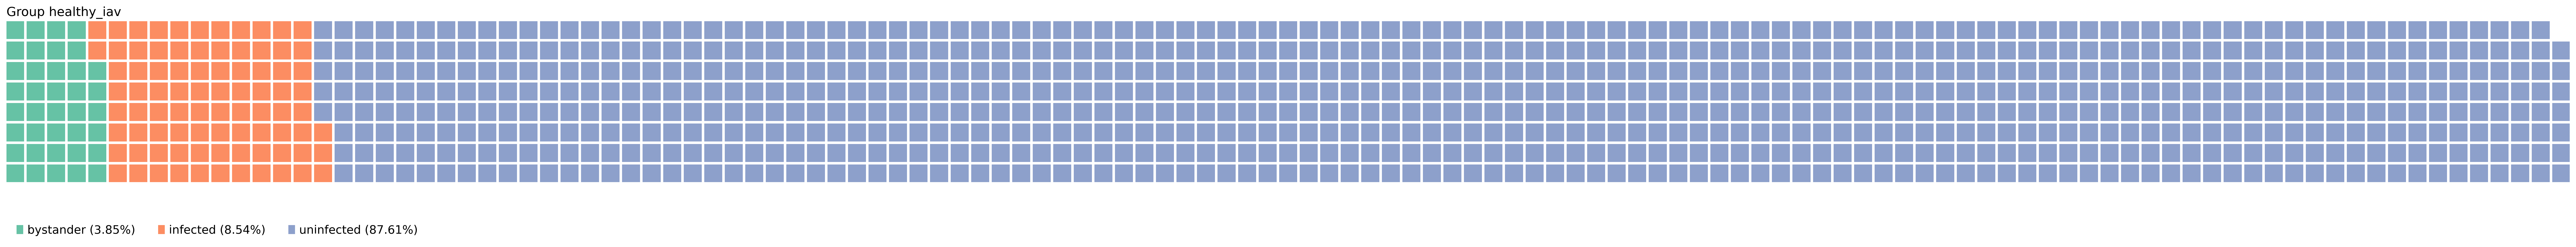

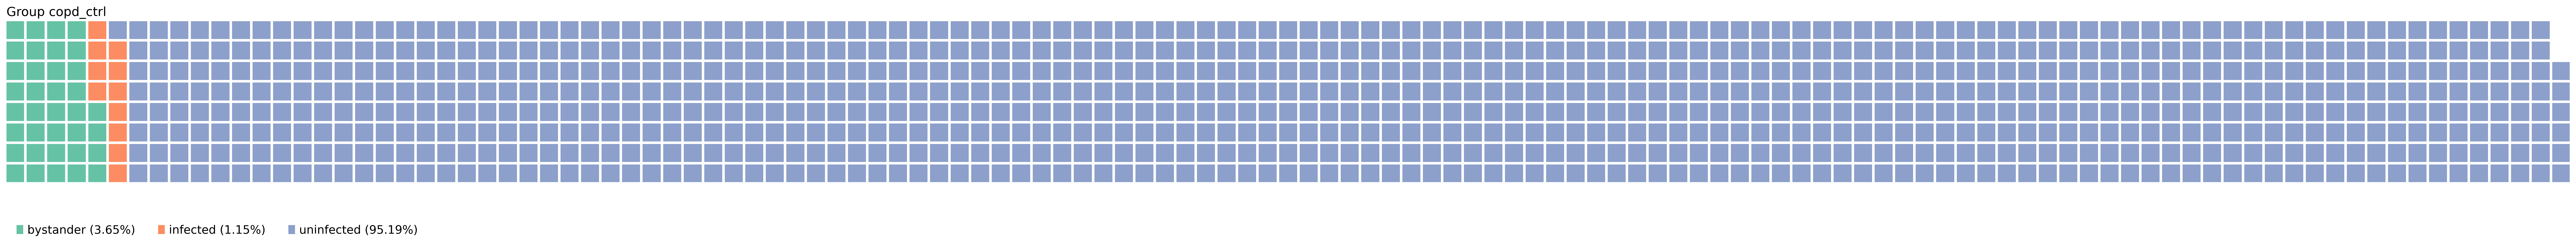

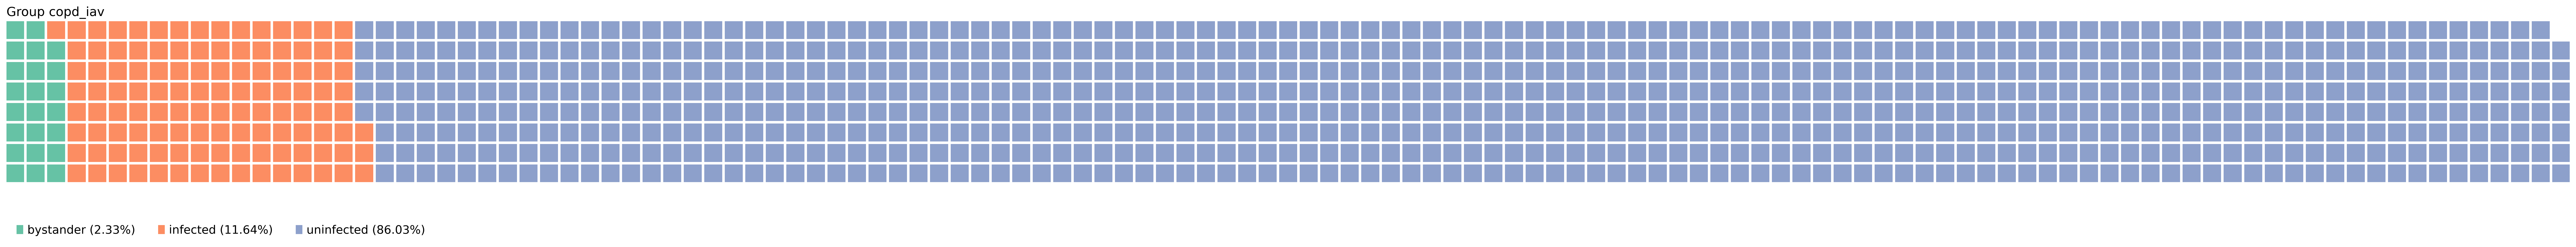

In [12]:
for group in df['group'].unique():
    temp_df = df[df['group'] == group]
    
    data = dict(zip(temp_df['infection_status'], temp_df['waffle_counts']))
    fig = plt.figure(
        FigureClass = Waffle, 
        rows = 8, 
        values = data, 
        title = {'label': f'Group {group}', 'loc': 'left'},
        labels = [f"{k} ({v}%)" for k, v in zip(temp_df['infection_status'], temp_df['proportions'].round(2))],
        #legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
        legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': 12, 'framealpha': 0},
        figsize = (40, 4)
    )
    plt.show()

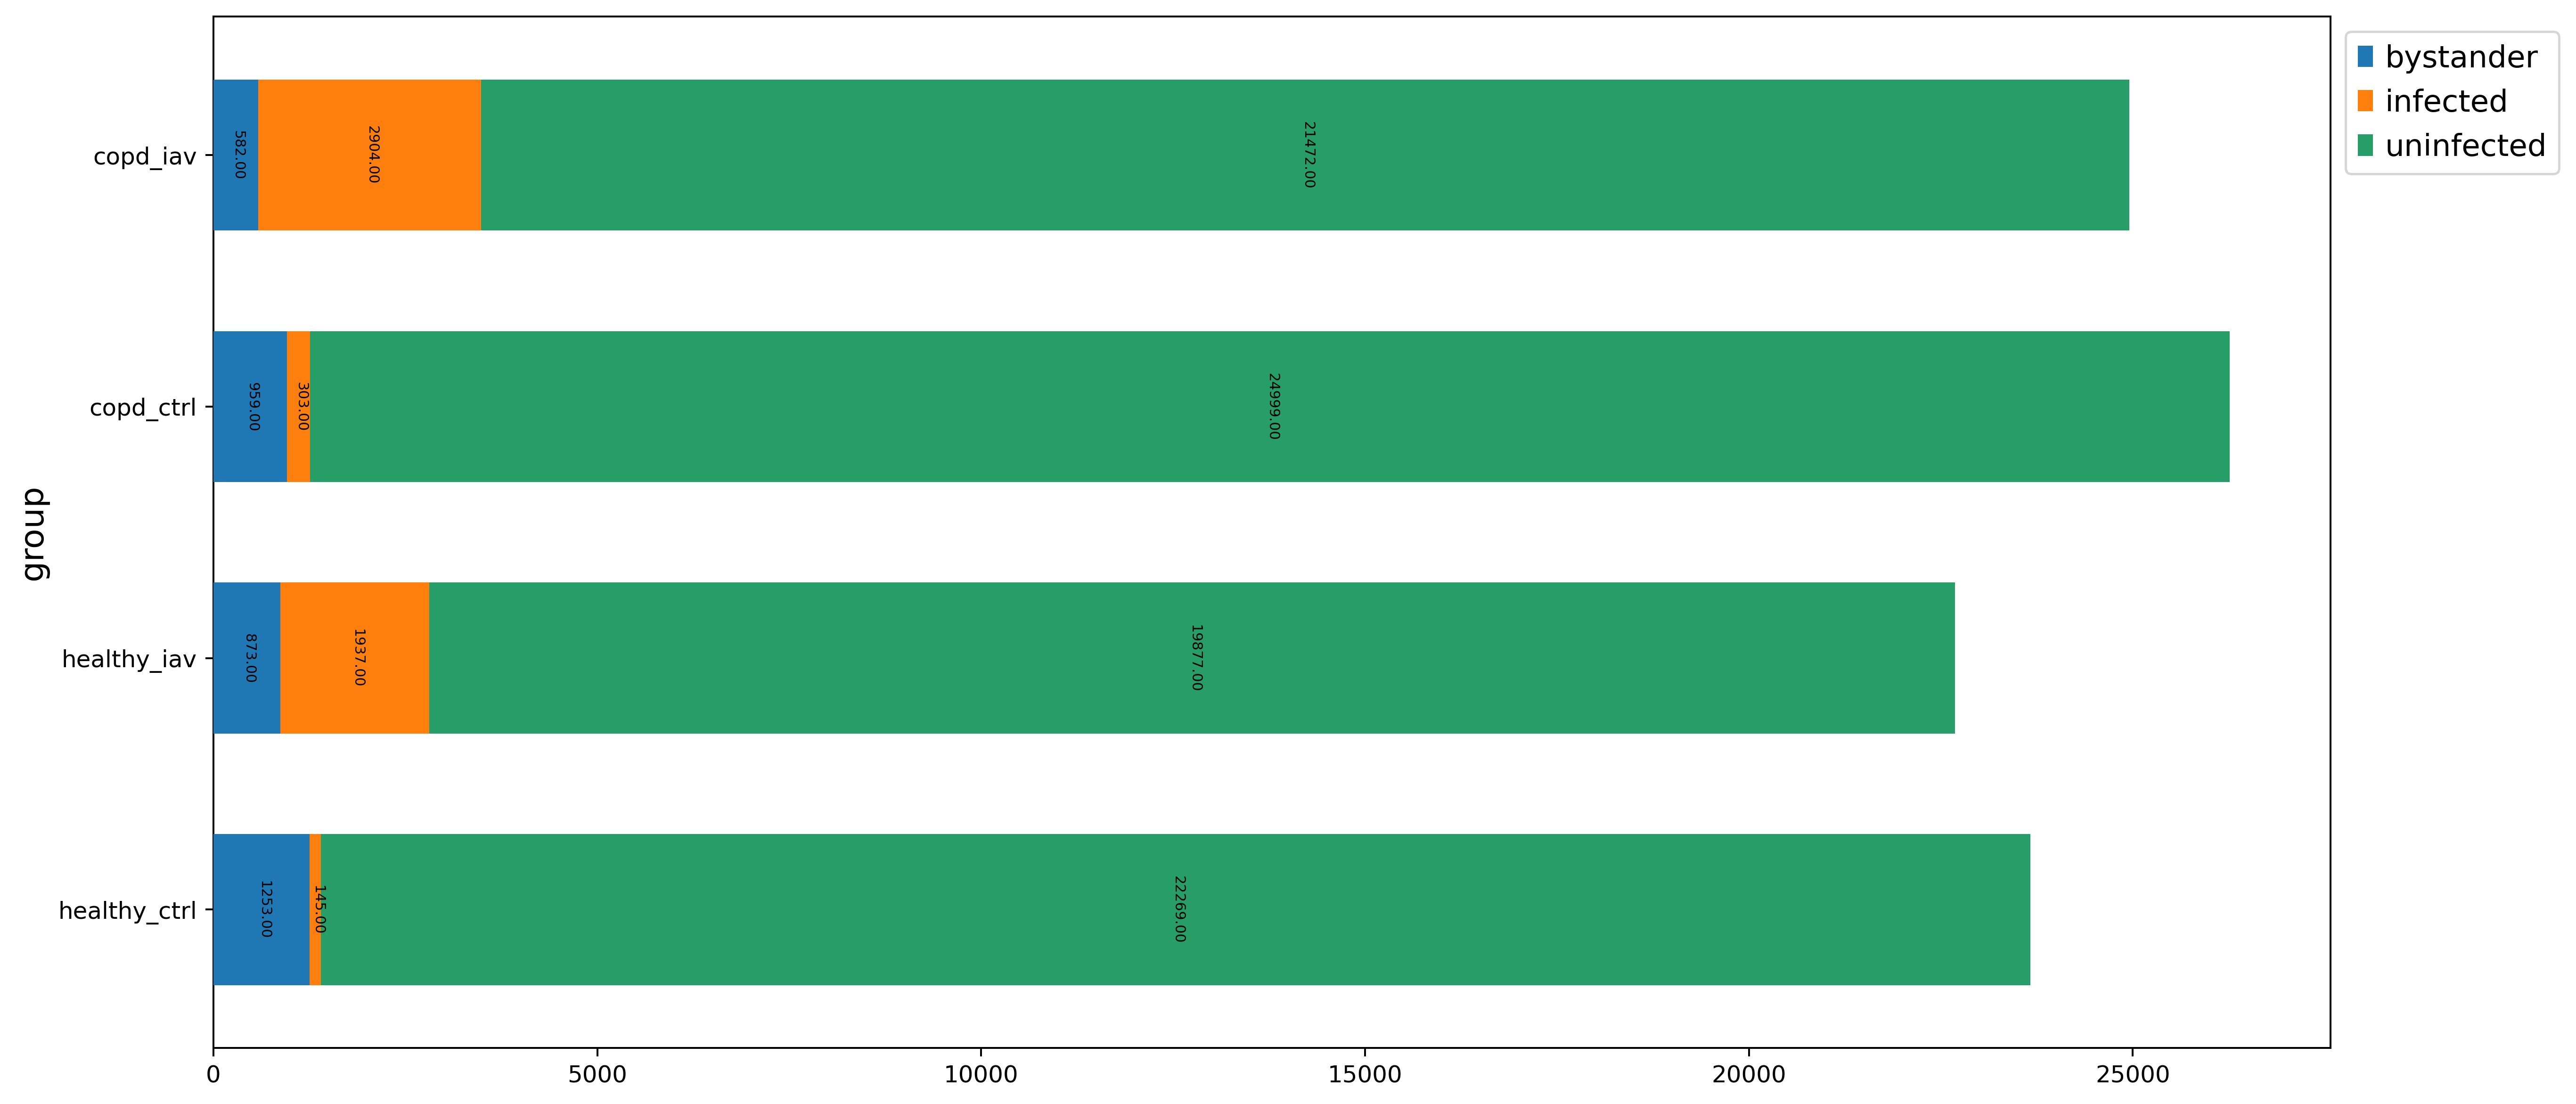

In [13]:
data = pd.crosstab(adata.obs['group'], adata.obs['infection_status'])

ax1 = data.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (16,8), fontsize = 10, grid = False, width = 0.6)
horiz_offset = 1.0
vert_offset = 1.0
ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset), ncol = 1)

for c in ax1.containers:
    
    labels = [f'{w:0.2f}' if (w := v.get_width()) > 0 else '' for v in c]
    ax1.bar_label(c, labels = labels, label_type = 'center', padding = 1, color = 'black', rotation = 270, fontsize = 6)